In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

data\arrhythmia.data
data\mitbih_test.csv
data\mitbih_train.csv
data\ptbdb_abnormal.csv
data\ptbdb_normal.csv
data\sample_submission.csv
data\test.csv
data\train.csv


In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

train_df = pd.read_csv("data/mitbih_train.csv", header=None)
test_df = pd.read_csv("data/mitbih_test.csv", header=None)
train_df.to_numpy()
test_df.to_numpy()

array([[1.        , 0.75826448, 0.11157025, ..., 0.        , 0.        ,
        0.        ],
       [0.90842491, 0.7838828 , 0.53113556, ..., 0.        , 0.        ,
        0.        ],
       [0.73008847, 0.21238938, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.96735907, 0.62017804, ..., 0.        , 0.        ,
        4.        ],
       [0.98412699, 0.5674603 , 0.60714287, ..., 0.        , 0.        ,
        4.        ],
       [0.97396964, 0.91323209, 0.86550975, ..., 0.        , 0.        ,
        4.        ]])

In [3]:
from sklearn.model_selection import train_test_split
x = train_df.loc[:,train_df.columns!=187]
y = train_df.loc[:,train_df.columns==187]
test_x = train_df.loc[:,test_df.columns!=187]
test_y = train_df.loc[:,test_df.columns==187]

train_x, val_x, train_y, val_y = train_test_split(x.to_numpy(), y.to_numpy(), test_size = 0.4)
# train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.25)

In [4]:
equilibre = y.value_counts()
print(equilibre)

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
dtype: int64


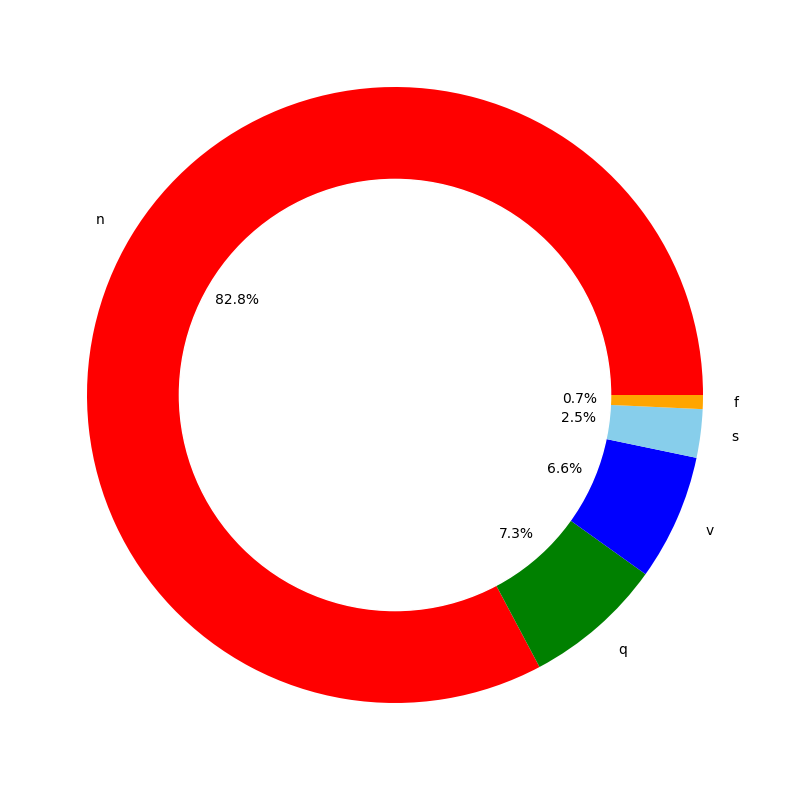

In [10]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [6]:
from xgboost import XGBClassifier
import xgboost
from wandb.xgboost import wandb_callback

my_model = XGBClassifier(silent=False,
                        tree_method="gpu_hist",
                        predictor="gpu_predictor")

N tree tuning

In [13]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

n_estimators = range(50, 400, 50)
param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(my_model, param_grid, scoring="accuracy", n_jobs=-1, cv=10, verbose=1)
grid_result = grid_search.fit(train_x, train_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 7 candidates, totalling 70 fits
[15:19:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Best: 0.953571 using {'n_estimators': 350}
0.937086 (0.002799) with: {'n_estimators': 50}
0.940227 (0.003179) with: {'n_estimators': 100}
0.942892 (0.002630) with: {'n_estimators': 150}
0.945443 (0.002382) with: {'n_estimators': 200}
0.947994 (0.002185) with: {'n_estimators': 250}
0.951115 (0.002124) with: {'n_estimators': 300}
0.953571 (0.001915) with: {'n_estimators': 350}


Learning rate and Ntree

In [20]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np
import time

start = time.time()
learning_rate = np.arange(0.03, 0.08, 0.01)
n_estimators = range(250, 400, 50)
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(my_model, param_grid, scoring="accuracy", n_jobs=-1, cv=10, verbose=1)
grid_result = grid_search.fit(train_x, train_y)
end = time.time()
print("Elapsed: ", end - start, "s")
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[18:02:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Elapsed:  3124.409304380417 s
Best: 0.977633 using {'learning_rate': 0.07, 'n_estimators': 350}
0.972245 (0.001462) with: {'learning_rate': 0.03, 'n_estimators': 250}
nan (nan) with: {'learning_rate': 0.03, 'n_estimators': 300}
0.974149 (0.001271) with: {'learning_rate': 0.03, 'n_estimators': 350}
0.973864 (0.001240) with: {'learning_rate': 0.04, 'n_estimators': 250}
0.974968 (0.001208) with: {'learning_rate': 0.04, 'n_estimators': 300}
0.975805 (0.001363) with: {'learning_rate': 0.04, 'n_estimators': 350}
0.974930 (

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np
import time

start = time.time()
learning_rate = np.arange(0.07, 0.1, 0.01)
n_estimators = range(350, 450, 50)
max_depth = range(5, 8, 1)
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(my_model, param_grid, scoring="accuracy", n_jobs=-1, cv=10, verbose=1)
grid_result = grid_search.fit(train_x, train_y)
end = time.time()
print("Elapsed: ", end - start, "s")
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 18 candidates, totalling 180 fits


OSError: [Errno 22] Invalid argument

In [4]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np
import time
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

In [5]:
min_child_weight = np.arange(0.1, 10.1, 0.1)

# Tuned Params
learning_rate = 0.07
n_estimators = 350

max_depth = range(5, 8, 1)
param_grid = dict(max_depth=max_depth)

start = time.time()
my_model = XGBClassifier(silent=False,
                        learning_rate= learning_rate,
                        n_estimators = n_estimators,
                        tree_method="gpu_hist",
                        predictor="gpu_predictor")
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(my_model, param_grid, scoring="accuracy", n_jobs=-1, cv=10, verbose=1)
grid_result = grid_search.fit(train_x, train_y)
end = time.time()
print("Elapsed: ", end - start, "s")
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[00:20:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Elapsed:  645.8508858680725 s
Best: 0.978223 using {'max_depth': 6}
0.976338 (0.001782) with: {'max_depth': 5}
0.978223 (0.001547) with: {'max_depth': 6}
nan (nan) with: {'max_depth': 7}



1 of kfold 10
[15:43:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




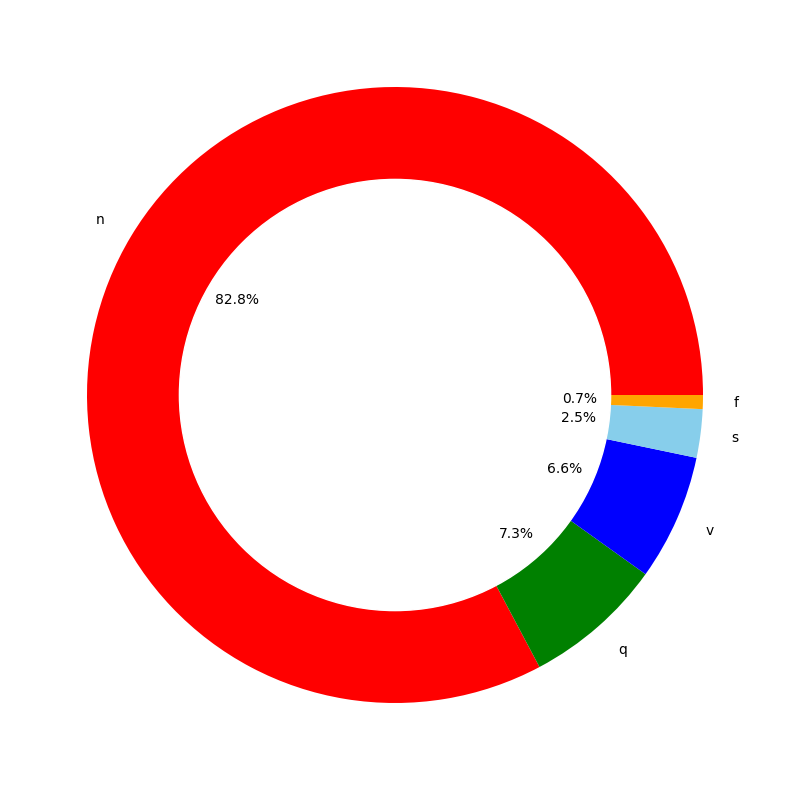

accuracy_score 0.9958425657308633

2 of kfold 10
[15:44:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




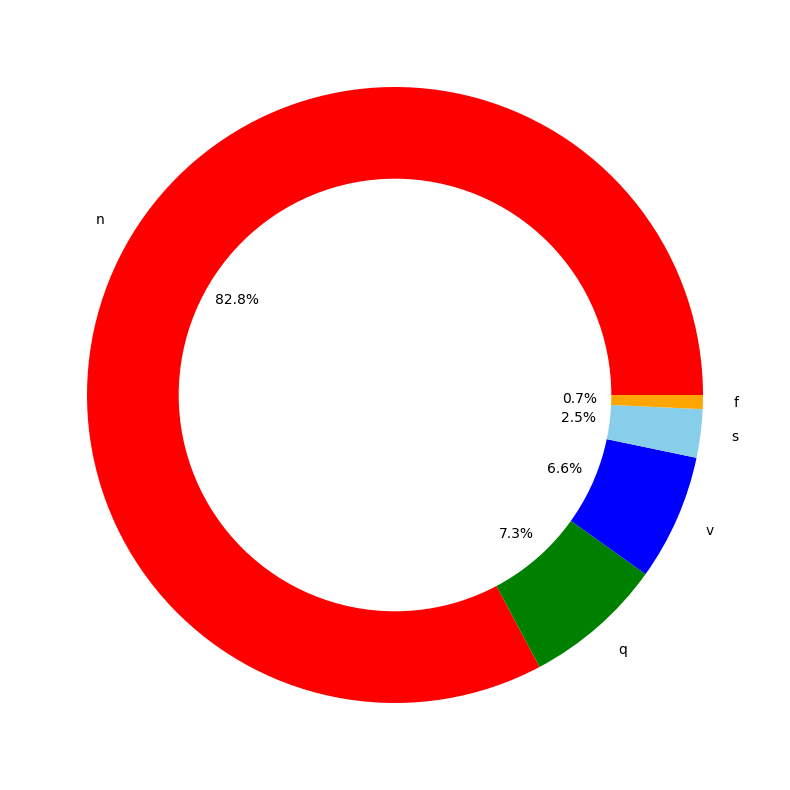

accuracy_score 0.9957169289809717

3 of kfold 10
[15:44:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




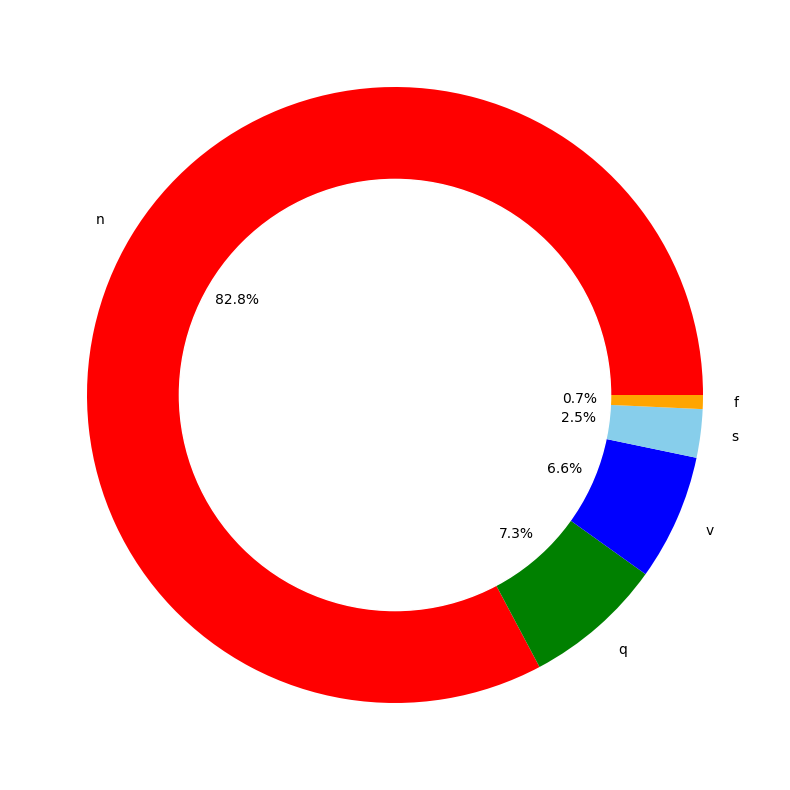

accuracy_score 0.9957968796399936

4 of kfold 10
[15:45:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




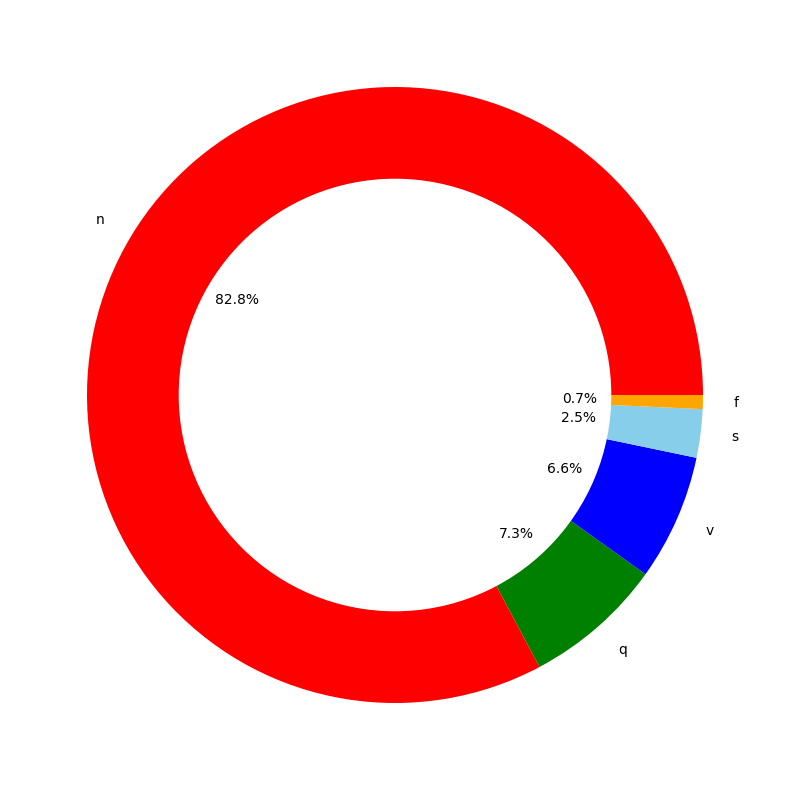

accuracy_score 0.9957397720264065

5 of kfold 10
[15:45:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




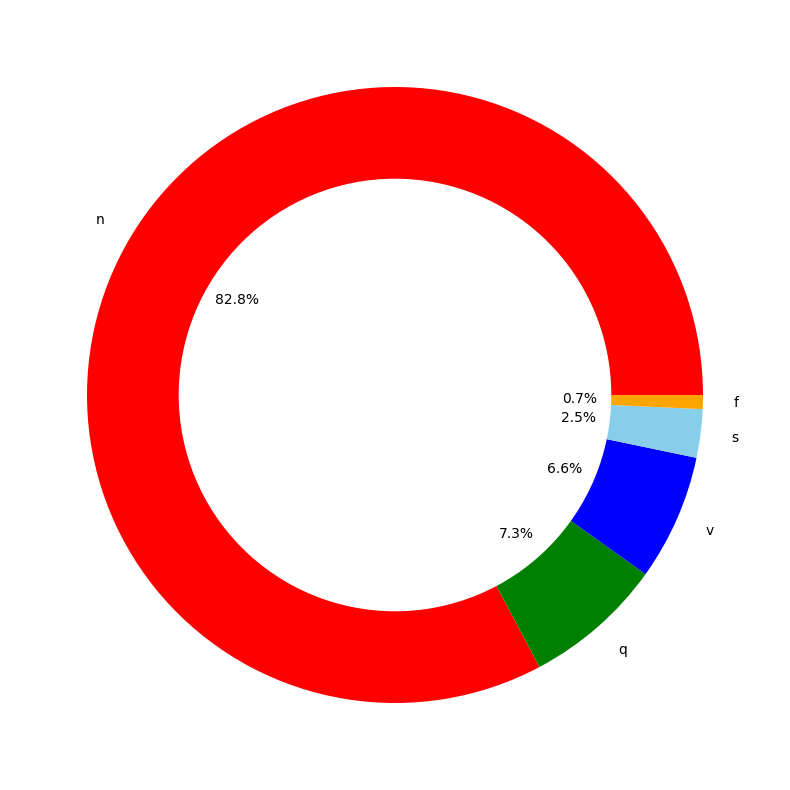

accuracy_score 0.9957626150718414

6 of kfold 10
[15:45:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




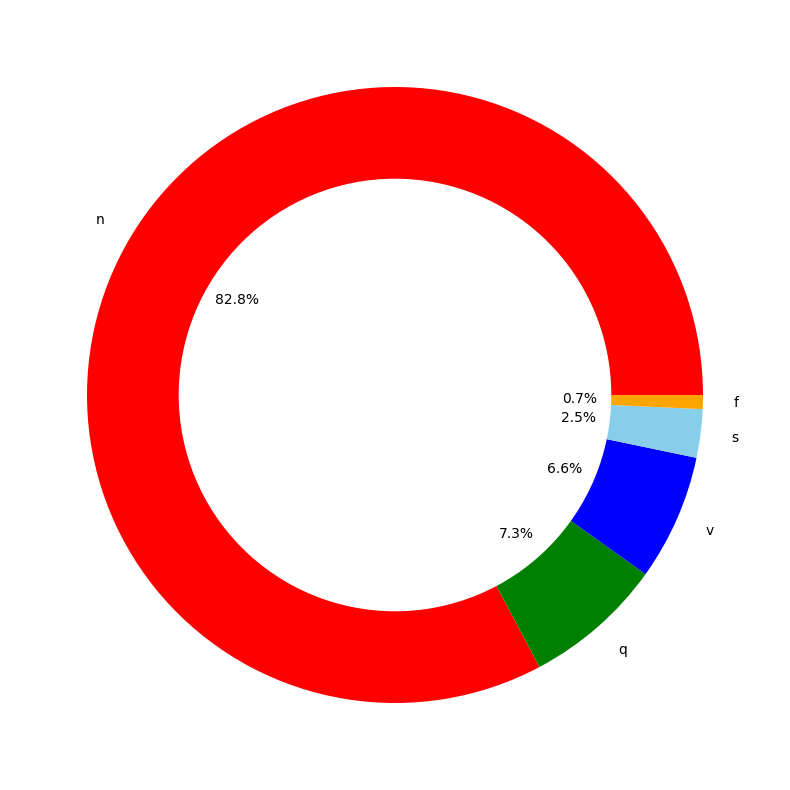

accuracy_score 0.9953971263448843

7 of kfold 10
[15:46:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




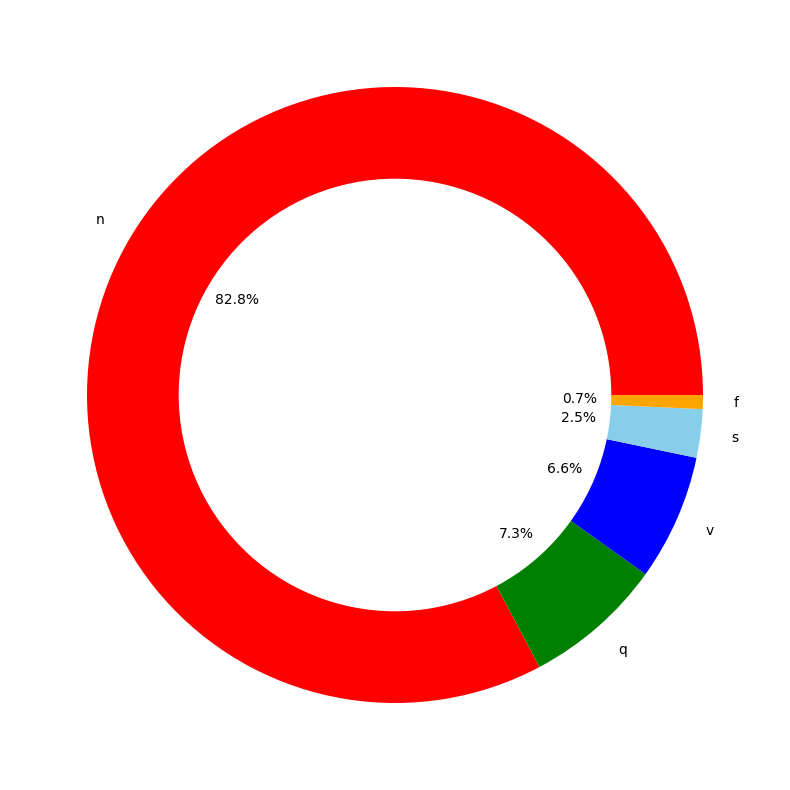

accuracy_score 0.9956255567992325

8 of kfold 10
[15:46:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




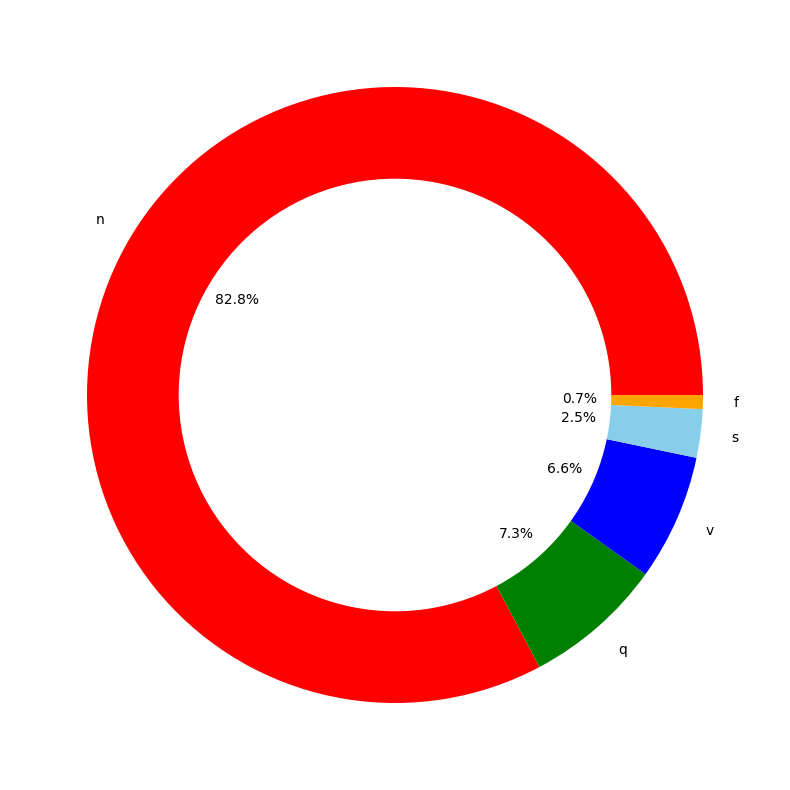

accuracy_score 0.9956027137537976

9 of kfold 10
[15:46:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




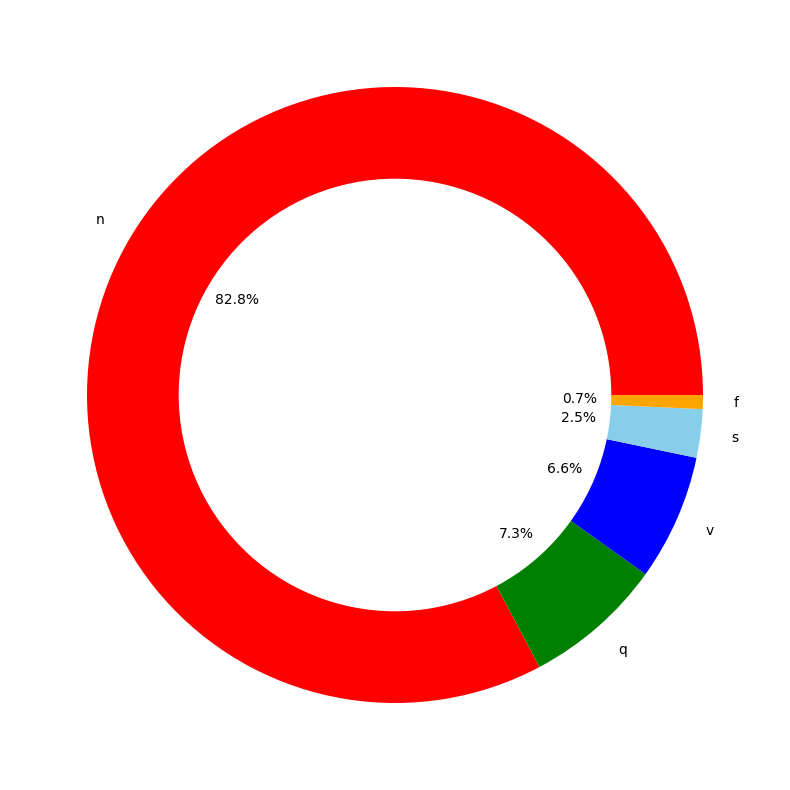

accuracy_score 0.9955456061402106

10 of kfold 10
[15:47:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




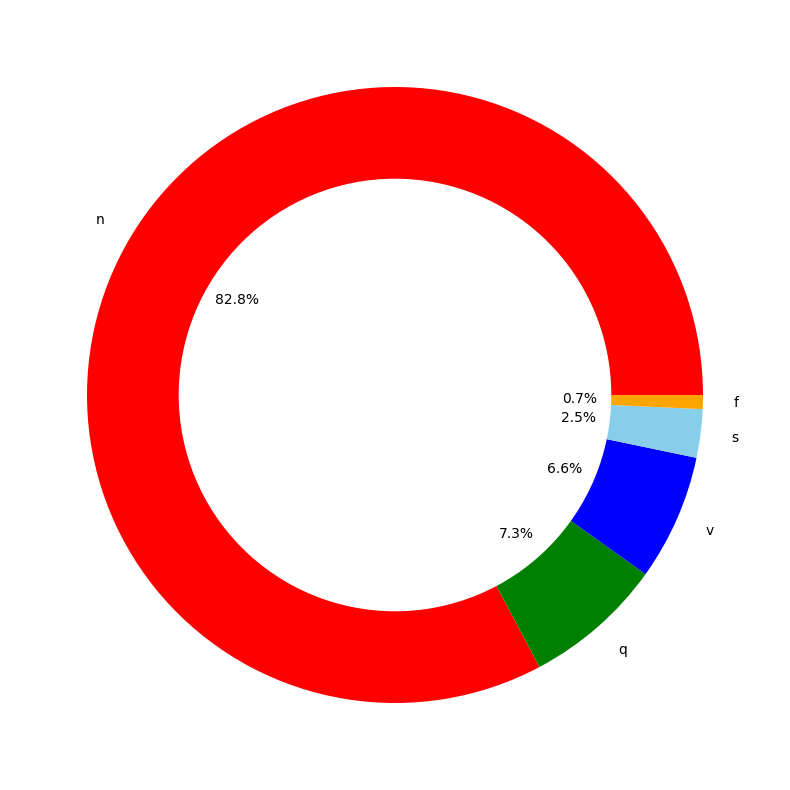

accuracy_score 0.9956598213673847


In [5]:
# Tuned Params
learning_rate = 0.07
n_estimators = 350
max_depth = 6

start = time.time()
my_model = XGBClassifier(silent=False,
                         learning_rate= learning_rate,
                         n_estimators = n_estimators,
                         max_depth = max_depth,
                         tree_method="gpu_hist",
                         predictor="gpu_predictor")
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
i=1
train_error_list = []
val_error_list = []
for train_index, val_index in kf.split(x, y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl = x.loc[train_index],x.loc[val_index]
    ytr,yvl = y.loc[train_index],y.loc[val_index]
    my_model.fit(xtr,ytr, eval_metric="merror", eval_set=[(xtr, ytr), (xvl, yvl)], verbose=False)
    pred=my_model.predict(test_x)
    results = my_model.evals_result()
    train_error_list.append(results["validation_0"]["merror"])
    val_error_list.append(results["validation_1"]["merror"])
    plt.figure(figsize=(20,10))
    my_circle=plt.Circle( (0,0), 0.7, color='white')
    plt.pie(ytr.value_counts(), labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()
    # print("Train error: ", results["validation_0"]["merror"])
    # print("Validation error: ", results["validation_1"]["merror"])
    print('accuracy_score', accuracy_score(test_y,pred))
    i += 1